In [1]:
# load all required libraries for Dog's Breed Identification Project
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [2]:
#read the csv file

df_labels = pd.read_csv("D:/Desktop/FYP/DogIdentificationV6/labels4.csv")
#store training and testing images folder location
train_file = r'D:/Desktop/FYP/DogIdentificationV6/Train/'
test_file = r'D:/Desktop/FYP/DogIdentificationV6/Test/'

In [3]:
#check the total number of unique breed in our dataset file
print("Total number of unique Dog Breeds :",len(df_labels.breed.unique()))

Total number of unique Dog Breeds : 55


In [4]:
print(df_labels['breed'].unique())

['Bichon_frise' 'Border_collie' 'british_bulldog' 'Cardigan_welsh_corgi'
 'Cavalier_king_charles_spaniel' 'Chihuahua' 'Chow_chow' 'Cocker_spaniel'
 'Dachshund' 'French_bulldog' 'Golden_retriever' 'Siberian_husky'
 'JapaneseSpitz' 'Jack_Russell_Terrier' 'Labrador_retriever' 'Maltese'
 'Miniature_schnauzer' 'Shih Tzu' 'West_highland_terrier'
 'Labrador_Retriever' 'Shetland_sheepdog' 'Pug' 'toy_poodle' 'Papillon'
 'Pembroke_welsh_corgi' 'Pomeranian' 'Poodle' 'Yorkshire_terrier'
 'Affenpinscher' 'Australian_terrier' 'Border_terrier' 'Boston_terrier'
 'Brussels_griffon' 'Cairn_terrier' 'Chinese_crested'
 'Dandie_dinmont_terrier' 'English_toy_spaniel' 'Italian_greyhound'
 'Japanese_chin' 'Lakeland_terrier' 'Lhasa_apso' 'Manchester_terrier'
 'Griffon_brabancon' 'Mexican_hairless' 'Toy_Terrier' 'Sealyham_Terrier'
 'Silky_Terrier' 'Schipperkee' 'Miniature_Pinscher' 'Norfolk_Terrier'
 'Pekingese' 'Scottish_Terrier' 'Shiba_Inu' 'Smooth_Fox_Terrier'
 'Tibetan_Mastiff']


In [5]:
#specify number
num_breeds = 55
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [6]:
#get only 55 unique breeds record 
breed_dict = list(df_labels['breed'].value_counts().keys()) 
new_list = sorted(breed_dict,reverse=True)[:num_breeds]
#change the dataset to have only those 60 unique breed records
df_labels = df_labels.query('breed in @new_list')

In [7]:
print(df_labels['breed'].unique())

['Bichon_frise' 'Border_collie' 'british_bulldog' 'Cardigan_welsh_corgi'
 'Cavalier_king_charles_spaniel' 'Chihuahua' 'Chow_chow' 'Cocker_spaniel'
 'Dachshund' 'French_bulldog' 'Golden_retriever' 'Siberian_husky'
 'JapaneseSpitz' 'Jack_Russell_Terrier' 'Labrador_retriever' 'Maltese'
 'Miniature_schnauzer' 'Shih Tzu' 'West_highland_terrier'
 'Labrador_Retriever' 'Shetland_sheepdog' 'Pug' 'toy_poodle' 'Papillon'
 'Pembroke_welsh_corgi' 'Pomeranian' 'Poodle' 'Yorkshire_terrier'
 'Affenpinscher' 'Australian_terrier' 'Border_terrier' 'Boston_terrier'
 'Brussels_griffon' 'Cairn_terrier' 'Chinese_crested'
 'Dandie_dinmont_terrier' 'English_toy_spaniel' 'Italian_greyhound'
 'Japanese_chin' 'Lakeland_terrier' 'Lhasa_apso' 'Manchester_terrier'
 'Griffon_brabancon' 'Mexican_hairless' 'Toy_Terrier' 'Sealyham_Terrier'
 'Silky_Terrier' 'Schipperkee' 'Miniature_Pinscher' 'Norfolk_Terrier'
 'Pekingese' 'Scottish_Terrier' 'Shiba_Inu' 'Smooth_Fox_Terrier'
 'Tibetan_Mastiff']


In [9]:
#create new column which will contain image name with the image extension
df_labels['img_file'] = df_labels['id'].apply(lambda x: x + ".jpg")

In [ ]:
#create a numpy array of the shape
#(number of dataset records, image size , image size, 3 for rgb channel ayer)
#this will be input for model
train_x = np.zeros((len(df_labels), im_size, im_size, 3), dtype='float32')
 
#iterate over img_file column of our dataset
for i, img_id in enumerate(df_labels['img_file']):

  #read the image file and convert into numeric format
  #resize all images to one dimension i.e. 224x224
  #we will get array with the shape of
  # (224,224,3) where 3 is the RGB channels layers
      img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
  #scale array into the range of -1 to 1.
  #preprocess the array and expand its dimension on the axis 0 
      img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
  #update the train_x variable with new element
      train_x[i] = img_array

In [24]:
#This will be the target for the model.
#convert breed names into numerical format
train_y = encoder.fit_transform(df_labels["breed"].values)

In [25]:
#split the dataset in the ratio of 80:20. 
#80% for training and 20% for testing purpose
x_train, x_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,random_state=42)

In [26]:
#Image augmentation using ImageDataGenerator class
train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
 
#generate images for training sets 
train_generator = train_datagen.flow(x_train, 
                                     y_train, 
                                     batch_size=batch_size)
 
#same process for Testing sets also by declaring the instance
test_datagen = ImageDataGenerator()
 
test_generator = test_datagen.flow(x_test, 
                                     y_test, 
                                     batch_size=batch_size)

In [27]:
#building the model using ResNet50V2 with input shape of our image array
#weights for our network will be from of imagenet dataset
#we will not include the first Dense layer
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
#freeze all trainable layers and train only top layers 
for layer in resnet.layers:
    layer.trainable = False
 
#add global average pooling layer and Batch Normalization layer
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
#add fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

In [28]:
#add output layer having the shape equal to number of breeds
predictions = Dense(num_breeds, activation='softmax')(x)
 
#create model class with inputs and outputs
model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

In [ ]:
#epochs for model training and learning rate for optimizer
epochs = 2
learning_rate = 1e-3
 
#using RMSprop optimizer to compile or build the model
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
 
#fit the training generator data and train the model
hist = model.fit(train_generator,
                 steps_per_epoch= x_train.shape[0] // batch_size,
                 epochs= epochs,
                 validation_data= test_generator,
                 validation_steps= x_test.shape[0] // batch_size)
 
#Save the model for prediction
model.save("D:\Desktop\FYP\DogIdentificationV6\model1-3-08-10")

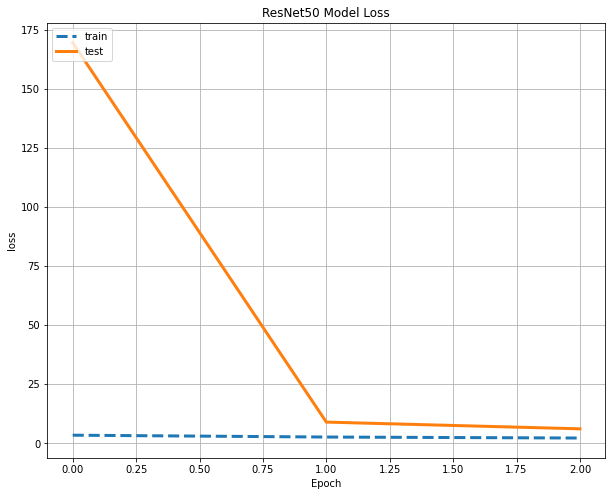

In [24]:
from matplotlib import pyplot as plt
## plot the history of loss and accuracy for train and valid data for the best model, Xception
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','test'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('ResNet50 Model Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

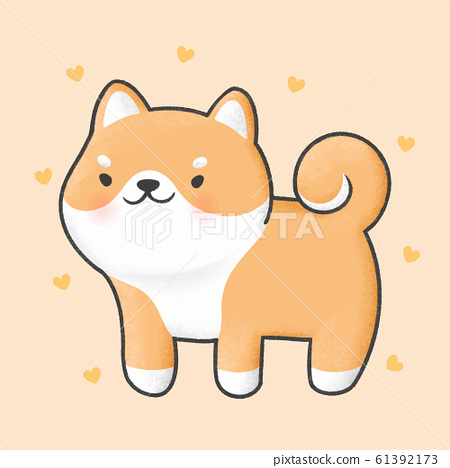

Predicted Breed for this Dog is : Shiba_Inu


In [25]:
from IPython.display import Image, display

#load the model
model = load_model("D:\Desktop\FYP\DogIdentificationV6\model1-3-08-10")
 
#get the image of the dog for prediction
pred_img_path = r'D:\Desktop\FYP\images\si2.jpg'


#read the image file and convert into numeric format
#resize all images to one dimension i.e. 224x224
pred_img_array = cv2.resize(cv2.imread(pred_img_path,cv2.IMREAD_COLOR),((im_size,im_size)))
#scale array into the range of -1 to 1.
#expand the dimension on the axis 0 and normalize the array values
pred_img_array = preprocess_input(np.expand_dims(np.array(pred_img_array[...,::-1].astype(np.float32)).copy(), axis=0))
 
#feed the model with the image array for prediction
pred_val = model.predict(np.array(pred_img_array,dtype="float32"))
 
#display the image of dog
display(Image(filename = pred_img_path, width = 600, height = 300))
#image = Image.open(pred_img_path)
#image.thumbnail((224, 224), Image.ANTIALIAS)
#image.save(pred_img_path, 'JPEG', quality=88)
    
#display the predicted breed of dog
pred_breed = sorted(new_list)[np.argmax(pred_val)]
print("Predicted Breed for this Dog is :",pred_breed)